In [1]:
import sys
import os
import numpy as np
import pyBigWig
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom
import pysam
from collections import defaultdict
from tqdm.notebook import tqdm

# Append the parent directory to sys.path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
from utils.bw_loader import bigwig_to_arrays_by_chrom

In [2]:
from pomegranate import BetaDistribution, State, PoissonDistribution, NormalDistribution, GeneralMixtureModel, HiddenMarkovModel

In [3]:
v1_1_genome_path = '/clusterfs/nilah/oberon/genomes/chm13.draft_v1.1.fasta'
endo_progen_lads = '/clusterfs/nilah/oberon/datasets/lamina_association_shah/GSM5669214_EndoProgenitor_LADs.bed'

In [4]:
gm12878_lmnb1_filepath = '/global/scratch/users/dixonluinenburg/whole_genome_bigwigs/2023-07_GM12878_LMNB1-accessibility/gm12878_'

In [16]:
genome_fasta = pysam.FastaFile(v1_1_genome_path)
chromosomes = [f'chr{num}' for num in range(1,23)]
chromosomes.append('chrX')
chrom_lengths_dict = {chromosome:genome_fasta.get_reference_length(chromosome) for chromosome in chromosomes}

In [7]:
chrom_lmnb1_dict = {}
for chromosome,length in chrom_lengths_dict.items():
    print('loading',chromosome) 
    chrom_lmnb1_dict[chromosome] = bigwig_to_arrays_by_chrom(gm12878_lmnb1_filepath+chromosome,
                                                              'gm12878_dimelo_feb2022_',
                                                              'mA',
                                                              chromosome,
                                                              0,length-1)

loading chr1
loading chr2
loading chr3
loading chr4
loading chr5
loading chr6
loading chr7
loading chr8
loading chr9
loading chr10
loading chr11
loading chr12
loading chr13
loading chr14
loading chr15
loading chr16
loading chr17
loading chr18
loading chr19
loading chr20
loading chr21
loading chr22
loading chrX


In [17]:
test_chroms = ['chr14','chrX']

In [18]:
binned_data_train_list = []
binned_data_test_list = []
bin_size = 200_000
for chromosome,(valid_array,mod_array) in chrom_lmnb1_dict.items():
    print('binning',chromosome)
    bins = np.arange(0,chrom_lengths_dict[chromosome]-1,bin_size)
    mod_data = np.nan_to_num(np.add.reduceat(mod_array,bins))
    valid_data = np.nan_to_num(np.add.reduceat(valid_array,bins))  
    if chromosome in test_chroms:
        binned_data_test_list.append(mod_data/(valid_data+0.01))
    else:
        binned_data_train_list.append(mod_data/(valid_data+0.01))

binning chr1
binning chr2
binning chr3
binning chr4
binning chr5
binning chr6
binning chr7
binning chr8
binning chr9
binning chr10
binning chr11
binning chr12
binning chr13
binning chr14
binning chr15
binning chr16
binning chr17
binning chr18
binning chr19
binning chr20
binning chr21
binning chr22
binning chrX


In [8]:
endo_lads_by_chrom = {chromosome:np.zeros(length) for chromosome,length in chrom_lengths_dict.items()}
with open(endo_progen_lads) as f:
    for line in f:
        fields = line.split('\t')
        if fields[0] in chrom_lengths_dict:
            endo_lads_by_chrom[fields[0]][int(fields[1]):int(fields[2])] = int(fields[3][1])
#             print(fields[3])
#         endo_lads_by_chrom[fields[0]].append((fields[1],fields[2],fields[3]))

In [14]:
print(binned_data_train_list)

NameError: name 'binned_data_train_list' is not defined

In [9]:
state1 = State(NormalDistribution(0,0.01))
state2 = State(NormalDistribution(0.01,0.1))
state3 = State(NormalDistribution(0.03,0.1))
model = HiddenMarkovModel(name='LADs')

In [10]:
model.add_transition(model.start,state1,0.3)
model.add_transition(model.start,state2,0.4)
model.add_transition(model.start,state3,0.3)
model.add_transition(state1, state1, 0.9)       # transition probability from state1 to state1
model.add_transition(state1, state2, 0.05)       # transition probability from state1 to state2
model.add_transition(state1, state3, 0.05)
model.add_transition(state2, state1, 0.05)       # transition probability from state2 to state1
model.add_transition(state2, state2, 0.9)
model.add_transition(state2, state3, 0.05)
model.add_transition(state3, state1, 0.05)       # transition probability from state2 to state1
model.add_transition(state3, state2, 0.05)
model.add_transition(state3, state3, 0.9)
model.add_transition(state1, model.end, 0.1)    # transition probability from state1 to end
model.add_transition(state2, model.end, 0.1)    # transition probability from state2 to end
model.add_transition(state3, model.end, 0.1)    # transition probability from state1 to end

In [11]:
model.bake()

In [19]:
model.fit(binned_data_train_list,max_iterations=100,stop_threshold=0.001)

{
    "class" : "HiddenMarkovModel",
    "name" : "LADs",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "LADs-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "LADs-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.011982375947193693,
                    0.005505902779223452
                ],
                "frozen" : false
            },
            "name" : "15baf930-f54d-4e1d-941b-347d6d60c471",
            "weight" : 1.0
        },
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "NormalDistribution",
                "parameters" : [
                    0.

In [20]:
state_map_dict = {
    0:1,
    1:0,
    2:2,
}

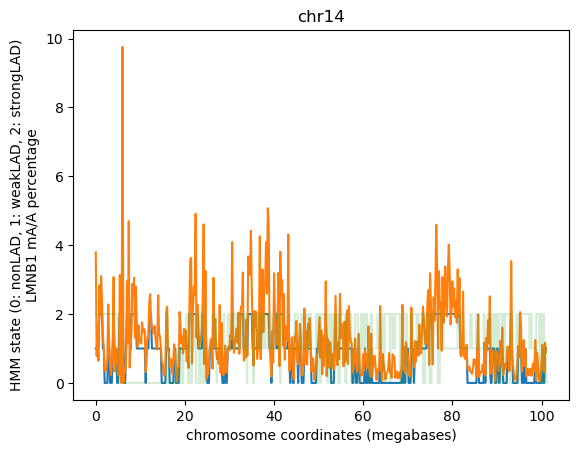

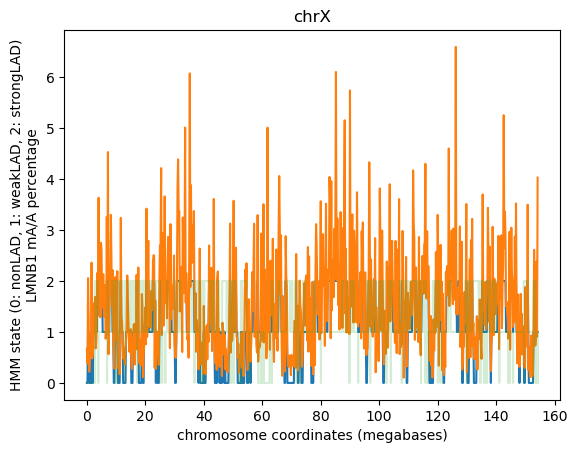

In [22]:
for idx,sequence in enumerate(binned_data_test_list):
    state_sequence = model.predict(sequence)
    state_sequence_remapped = [state_map_dict[state] for state in state_sequence]
    x_len = len(sequence)
    x_array = bin_size*np.arange(0,x_len)/1000000
    plt.plot(x_array,state_sequence_remapped)
    plt.plot(x_array,sequence*100)
    endo_lads_len = len(endo_lads_by_chrom[test_chroms[idx]])
    plt.plot(np.arange(0,endo_lads_len)/1000000,endo_lads_by_chrom[test_chroms[idx]],alpha=0.2)
    plt.title(test_chroms[idx])
    plt.xlabel('chromosome coordinates (megabases)')
    plt.ylabel('HMM state (0: nonLAD, 1: weakLAD, 2: strongLAD)\nLMNB1 mA/A percentage')
    plt.show()